In [111]:
import numpy as np
import pandas as pd
import tqdm as tqdm
# 繁体中文使用big5编码
train_data = pd.read_csv('./ml2020spring-hw1/train.csv', encoding='big5')

In [112]:
train_data.head()

,日期,測站,測項,0,1,2,3,4,5,6,...,14,15,16,17,18,19,20,21,22,23
0,2014/1/1,豐原,AMB_TEMP,14,14,14,13,12,12,12,...,22,22,21,19,17,16,15,15,15,15
1,2014/1/1,豐原,CH4,1.8,1.8,1.8,1.8,1.8,1.8,1.8,...,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8
2,2014/1/1,豐原,CO,0.51,0.41,0.39,0.37,0.35,0.3,0.37,...,0.37,0.37,0.47,0.69,0.56,0.45,0.38,0.35,0.36,0.32
3,2014/1/1,豐原,NMHC,0.2,0.15,0.13,0.12,0.11,0.06,0.1,...,0.1,0.13,0.14,0.23,0.18,0.12,0.1,0.09,0.1,0.08
4,2014/1/1,豐原,NO,0.9,0.6,0.5,1.7,1.8,1.5,1.9,...,2.5,2.2,2.5,2.3,2.1,1.9,1.5,1.6,1.8,1.5


In [113]:
train_dict = {}
for idx, col in enumerate(train_data['測項'].unique()):
    if idx == 0:
        train_dict['date'] = pd.to_datetime(np.repeat(train_data[train_data['測項'] == col]['日期'].values, 24))
        train_dict['hour'] = pd.to_numeric(np.tile(train_data[train_data['測項'] == col].columns[3:],240)) 
#     print(col)
    if col == 'RAINFALL':
        tmp_array = train_data[train_data['測項'] == col].T.iloc[3:].values.flatten(order='F')
        tmp_array[tmp_array=='NR'] = -1
        train_dict[col] = pd.to_numeric(tmp_array)
    else:
        train_dict[col] = pd.to_numeric(train_data[train_data['測項'] == col].T.iloc[3:].values.flatten(order='F'))

In [102]:
np.unique(train_data[train_data['測項'] == 'RAINFALL'].T.iloc[3:].values.flatten(order='F'))

array(['0', '0.2', '0.4', '0.6', '0.8', '1', '1.2', '1.4', '1.6', '1.8',
       '10', '11', '12', '13', '14', '15', '17', '18', '19', '2', '2.2',
       '2.4', '2.6', '2.8', '20', '21', '23', '27', '3', '3.2', '3.4',
       '3.6', '3.8', '38', '4', '4.2', '4.6', '4.8', '5', '5.4', '56',
       '6.4', '6.8', '66', '7', '7.2', '7.4', '7.6', '7.8', '74', '8.2',
       '8.4', '8.6', '9.2', '9.8', 'NR'], dtype=object)

In [114]:
train_data = pd.DataFrame(train_dict)
train_data.head()

,date,hour,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
0,2014-01-01,0,14.0,1.8,0.51,0.20,0.9,16.0,17.0,16.0,56,26,-1.0,77,1.8,2.0,37.0,35.0,1.4,0.5
1,2014-01-01,1,14.0,1.8,0.41,0.15,0.6,9.2,9.8,30.0,50,39,-1.0,68,2.0,2.0,80.0,79.0,1.8,0.9
2,2014-01-01,2,14.0,1.8,0.39,0.13,0.5,8.2,8.7,27.0,48,36,-1.0,67,1.7,2.0,57.0,2.4,1.0,0.6
3,2014-01-01,3,13.0,1.8,0.37,0.12,1.7,6.9,8.6,23.0,35,35,-1.0,74,1.6,1.9,76.0,55.0,0.6,0.3
4,2014-01-01,4,12.0,1.8,0.35,0.11,1.8,6.8,8.5,24.0,25,31,-1.0,72,1.9,1.9,110.0,94.0,1.7,0.6


In [104]:
# 皮尔森相关系数
corr = train_data.corr()
corr['PM2.5'].sort_values()

RH           -0.264196
WIND_SPEED   -0.084703
RAINFALL     -0.070448
WS_HR        -0.045458
AMB_TEMP     -0.017127
NO            0.029970
WIND_DIREC    0.156990
hour          0.168017
WD_HR         0.186138
CH4           0.254657
CO            0.283119
NMHC          0.291778
THC           0.352159
O3            0.356670
SO2           0.370831
NOx           0.375564
NO2           0.449113
PM10          0.776426
PM2.5         1.000000
Name: PM2.5, dtype: float64

In [105]:
# 数据集切分
X_train = train_data[['hour', 'AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx',
       'O3', 'PM10', 'RAINFALL', 'RH', 'SO2', 'THC', 'WD_HR',
       'WIND_DIREC', 'WIND_SPEED', 'WS_HR']]
y_train = train_data['PM2.5']

## 批量梯度下降

In [10]:
np.random.seed(0)

learning_rate = 0.01
n_iter = 1000
def BatchGradientDescent(X, y, n_iter, learning_rate):
    n_samples = X.shape[0]
    n_features = X.shape[-1]
    theta = np.zeros(n_features)
    
    for i in range(n_iter):
        error = X.dot(theta) - y 
        loss = error.dot(error) / (2 * n_samples)
        grad = X.T.dot(error) / n_samples
        theta = theta - learning_rate * grad
    return theta, loss

In [53]:
# 标准化
X = (X_train - X_train.mean())/X_train.std()
# 截距项
X = np.c_[np.ones(X.shape[0]), X]
theta, loss = BatchGradientDescent(X, y_train, n_iter, learning_rate)
loss

49.02919534257987

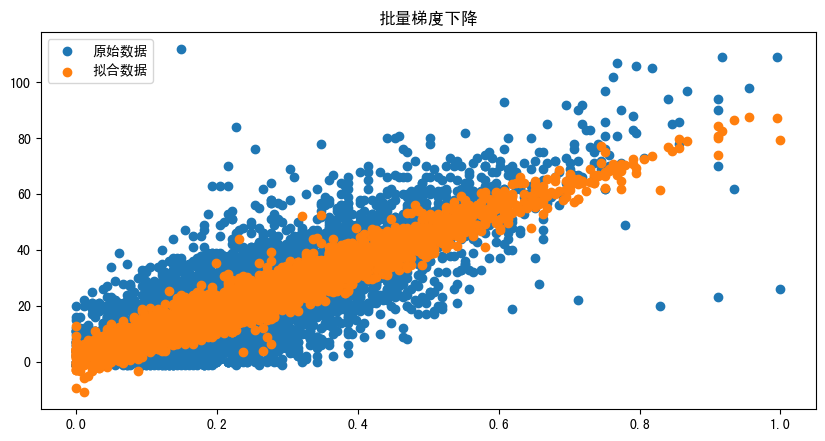

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,5), dpi=100)

plt.scatter(X_train['PM10'], y_train, label='原始数据')
plt.scatter(X_train['PM10'], X.dot(theta), label='拟合数据')
plt.title('批量梯度下降')
plt.legend()

In [55]:
fig.savefig('批量梯度下降.png')

In [14]:
# 归一化
X_train = (X_train - X_train.min())/X_train.max()
# 截距项
X = np.c_[np.ones(X.shape[0]), X]
theta, loss = BatchGradientDescent(X, y_train, n_iter, learning_rate)
loss

49.02919490657237

## 随机梯度下降

In [44]:
np.random.seed(0)

learning_rate = 0.01
n_iter = 1000
def StochasticGradientDescent(X, y, n_iter, learning_rate):
    n_samples = X.shape[0]
    n_features = X.shape[-1]
    theta = np.zeros(n_features)
    
    latest_loss = 0
    for i in range(n_iter):
        idx_range = np.arange(n_samples)
        loss = 0
        while len(idx_range) > 0:
            idx = np.random.choice(idx_range)
            idx_range = np.delete(idx_range, np.where(idx_range==idx))
            error = X[idx].dot(theta) - y[idx]
            loss = loss + np.power(error, 2)
            grad = X[idx].T.dot(error)
            theta = theta - learning_rate * grad
        loss = loss / (2 * n_samples)
        if abs(latest_loss - loss) < 1e-5:
            return theta, loss
        latest_loss = loss
    return theta, loss  

In [45]:
# 标准化
X = (X_train - X_train.mean())/X_train.std()
# 截距项
X = np.c_[np.ones(X.shape[0]), X]
theta, loss = StochasticGradientDescent(X, y_train, n_iter, learning_rate)
loss

60.78653310176898

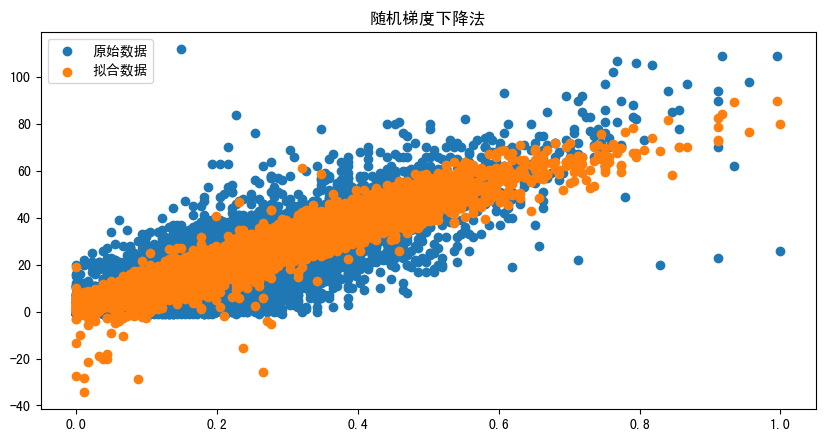

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,5), dpi=100)

plt.scatter(X_train['PM10'], y_train, label='原始数据')
plt.scatter(X_train['PM10'], X.dot(theta), label='拟合数据')
plt.title('随机梯度下降法')
plt.legend()

In [52]:
fig.savefig('随机梯度下降法.png')

## RMSProp

In [115]:
np.random.seed(0)

learning_rate = 0.01
n_iter = 1000
def RMSProp(X, y, n_iter, learning_rate, batch_size=10):
    gamma = 0.9
    epsilon = 1e-6
    
    n_samples = X.shape[0]
    n_features = X.shape[-1]
    theta = np.zeros(n_features)
    exp_gradient = np.zeros(n_features)
    
    X_y = np._c[X, y]
    latest_loss = 0
    
    for i in range(n_iter):
        np.random.shuffle(X_y)
        y_ = X_y[:, -1]
        X_ = X_y[:, :-1]
        loss = 0
        for j in range(0, n_samples,batch_size):
            min_X = X_[j: j + batch_size, :]
            min_y = y_[j: j + batch_size]
            error = min_X.dot(theta) - min_y 
            loss += error.dot(error)
            grad = min_X.T.dot(error) / batch_size
            exp_gradient = gamma*exp_gradient + (1 - gamma)*np.power(grad, 2)
            rms_gradient = np.sqrt(exp_gradient + epsilon)
            theta -= learning_rate*grad / rms_gradient
        loss = loss / (2 * n_samples)
        if abs(loss - latest_loss) < 1e-5:
            return theta, loss
        latest_loss = loss
    return theta, loss

In [116]:
# 标准化
X = (X_train - X_train.mean())/X_train.std()
# 截距项
X = np.c_[np.ones(X.shape[0]), X]
theta, loss = StochasticGradientDescent(X, y_train, n_iter, learning_rate)
loss

60.78653310176674

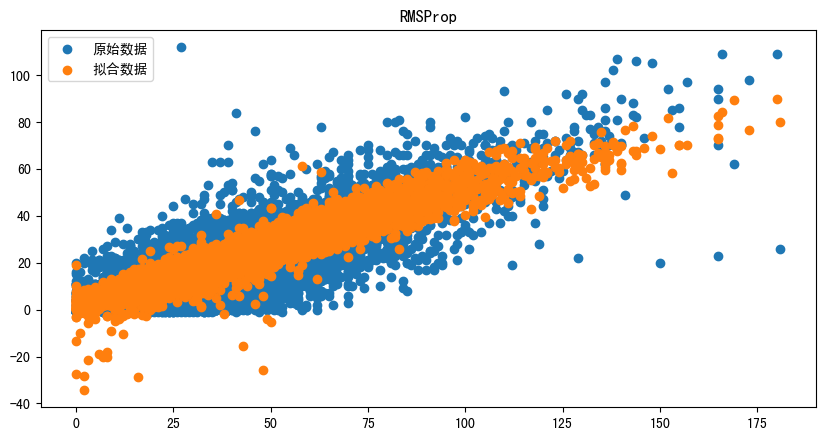

In [117]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,5), dpi=100)

plt.scatter(X_train['PM10'], y_train, label='原始数据')
plt.scatter(X_train['PM10'], X.dot(theta), label='拟合数据')
plt.title('RMSProp')
plt.legend()

In [118]:
fig.savefig('RMSProp.png')